<a href="https://colab.research.google.com/github/anuragjain0610/Sentiment-Analysis-Amazon-Reviews/blob/master/amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import json
import numpy as np
from tqdm import tqdm
import gzip
import string
import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import calendar
import pickle

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.externals import joblib

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
def read_json(file):
    data = []
    with open(file) as f:
        for l in tqdm(f):
            data.append(json.loads(l.strip()))
    return data 

def read_jsonzip(file):
    data = []
    with gzip.open(file) as f:
        for l in tqdm(f):
            data.append(json.loads(l.strip()))
    return data      

In [0]:
data1 = read_json('AMAZON_FASHION.json')
# total length of list, this number equals total number of products
print(len(data1))

# first row of the list
print(data1[0])

883636it [00:08, 106316.55it/s]


883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [0]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data1)

print(len(df))
df.shape

883636


(883636, 12)

In [0]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


In [0]:
df1 = df[['overall', 'verified', 'reviewerID', 'reviewText', 'summary', 'unixReviewTime']]
df1.head()

,overall,verified,reviewerID,reviewText,summary,unixReviewTime
0,5.0,True,A1D4G1SNUZWQOT,Exactly what I needed.,perfect replacements!!,1413763200
1,2.0,True,A3DDWDH9PX2YX2,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400
2,4.0,False,A2MWC41EW7XL15,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800
3,2.0,True,A2UH2QQ275NV45,too tiny an opening,Two Stars,1408838400
4,3.0,False,A89F3LQADZBS5,Okay,Three Stars,1406419200


In [0]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"])

In [0]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,pos_neg
0,5.0,True,2014-10-20,A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,1
1,2.0,True,2014-09-28,A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN,0
2,4.0,False,2014-08-25,A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,1
3,2.0,True,2014-08-24,A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,0
4,3.0,False,2014-07-27,A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,0


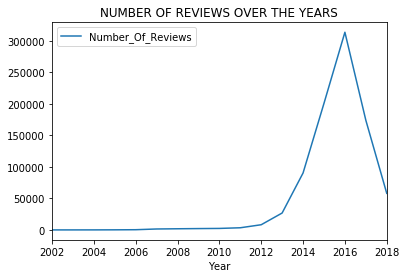

In [0]:
df['Year']=df['reviewTime'].dt.year
Yearly=df.groupby(['Year'])['reviewerID'].count().reset_index()
Yearly=Yearly.rename(columns={'reviewerID': 'Number_Of_Reviews'})
Yearly.plot(x="Year", y="Number_Of_Reviews", kind="line", title="NUMBER OF REVIEWS OVER THE YEARS")
plt.show()

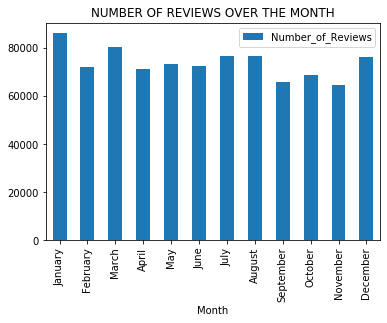

In [0]:
df['Month']=df['reviewTime'].dt.month
Monthly=df.groupby(['Month'])['reviewerID'].count().reset_index()
Monthly['Month'] = Monthly['Month'].apply(lambda x: calendar.month_name[x])
Monthly=Monthly.rename(columns={'reviewerID':'Number_of_Reviews'})
Monthly.plot(x="Month", y="Number_of_Reviews", kind="bar", title="NUMBER OF REVIEWS OVER THE MONTH")
plt.show()

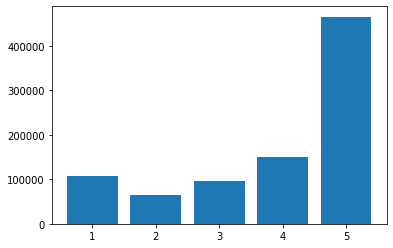

In [0]:
summarised_results = df['overall'].value_counts()
plt.bar(summarised_results.keys(), summarised_results.values)
plt.show()

In [0]:
products = df['overall'].groupby(df['asin']).count()
products.head()
print("Number of Unique Products in the category = {}".format(products.count()))

Number of Unique Products in the category = 186189


In [0]:
sorted_products = products.sort_values(ascending=False)
print("Top 20 Reviewed Products:\n")
print(sorted_products[:20], end='\n\n')
print('Most Reviewed Product, B000V0IBDM - has {} reviews.'.format(products.max()))

Top 20 Reviewed Products:

asin
B000V0IBDM    4384
B000KPIHQ4    4375
B00I0VHS10    3889
B00RLSCLJM    3638
B000PHANNM    2572
B000YFSR5G    2538
B00201ER88    2206
B00GXE331K    2027
B000P0X15G    1928
B00XT15P8E    1855
B0017U1KBK    1828
B005N7YWX6    1688
B004HX6P1E    1680
B000YFSR4W    1650
B009RUKQ2G    1592
B000JOOR7O    1588
B00ZW3SCF0    1541
B000GHRZN2    1418
B000GHMRLW    1418
B00XTM0ZPG    1408
Name: overall, dtype: int64

Most Reviewed Product, B000V0IBDM - has 4384 reviews.


In [0]:
products.mode()

0    1
dtype: int64

# Preprocessing:
### Remove punctuations, stopwords, and lemmatize

In [0]:
df1['reviewText'][:11]

0                                Exactly what I needed.
1     I agree with the other review, the opening is ...
2     Love these... I am going to order another pack...
3                                   too tiny an opening
4                                                  Okay
5                                Exactly what I wanted.
6     These little plastic backs work great.  No mor...
7     mother - in - law wanted it as a present for h...
8     Item is of good quality. Looks great, too. But...
9     I had used my last el-cheapo fake leather ciga...
10    This brand has been around a long time and you...
Name: reviewText, dtype: object

In [0]:
reviews = df1['reviewText']
reviews.count()

882403

In [0]:
stops = stopwords.words('english')

In [0]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [0]:
reviews = reviews.apply(lambda x: tokenize(str(x)))

In [0]:
reviews[:11]

0                          [Exactly, what, I, needed, ]
1     [I, agree, with, the, other, review, , the, op...
2     [Love, these, , I, am, going, to, order, anoth...
3                              [too, tiny, an, opening]
4                                                [Okay]
5                          [Exactly, what, I, wanted, ]
6     [These, little, plastic, back, work, great, , ...
7     [mother, , in, , law, wanted, it, a, a, presen...
8     [Item, is, of, good, quality, , Looks, great, ...
9     [I, had, used, my, last, elcheapo, fake, leath...
10    [This, brand, ha, been, around, a, long, time,...
Name: reviewText, dtype: object

# Modelling

In [0]:
reviewText = df.reviewText.apply(lambda x : str(x))
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, 
                            relative_scaling=1).generate(' '.join(reviewText))

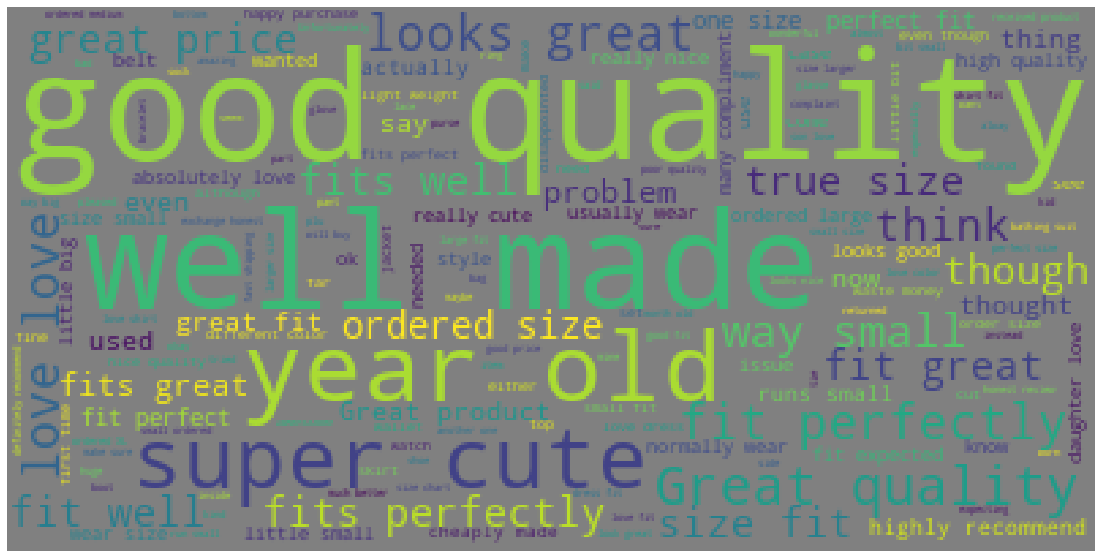

In [0]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);

## Insert pos_neg column for Sentiment modeling
     Negative reviews:      1-3 Stars  = 0
     Positive reviews:      4-5 Stars  = 1

In [0]:
df['pos_neg'] = [1 if x > 3 else 0 for x in df.overall]

In [0]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,pos_neg
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,1
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN,0
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,1
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,0
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,0


In [0]:
x_train, x_test, y_train, y_test = train_test_split(reviewText, df.pos_neg, random_state=0)

In [0]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (662727,)
y_train shape: (662727,)

x_test shape: (220909,)
y_test shape: (220909,)



# Logistic Regression
### Count Vectorizer

In [0]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
# pickle.dump(vectorizer, open("vector.pickel", "wb"))
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<662727x21531 sparse matrix of type '<class 'numpy.int64'>'
	with 13909581 stored elements in Compressed Sparse Row format>


In [0]:
pickle.dump(vectorizer, open("vector.pickel", "wb"))

In [0]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 21531


### Logistic Regression on training data

In [0]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [0]:
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.888


In [0]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

log_y_pred = logreg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
logreg_score = accuracy_score(y_test, log_y_pred)
print("Accuracy:   {:.3f}".format(logreg_score))

Accuracy:   0.886


In [0]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.890
Test set score: 0.886


In [0]:
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 52057  15340]
 [  9868 143644]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


In [0]:
# plt.imshow(log_cfm, interpolation='nearest')
# for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
#     plt.text(j, i, log_cfm[i, j],
#              horizontalalignment="center",
#              color="white")

# plt.ylabel('True label (Recall)')
# plt.xlabel('Predicted label (Precision)')
# plt.title('Logistic Reg | Confusion Matrix')
# plt.colorbar();

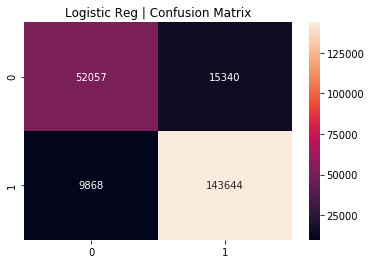

In [0]:
plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
sns.heatmap(log_cfm, annot=True, fmt="d")
plt.show()

In [0]:
log_f1 = f1_score(y_test, log_y_pred)
print("Logistic Reg - F1 score: {:.3f}".format(log_f1))

Logistic Reg - F1 score: 0.919


In [0]:
# save the model to disk
filename = 'finalized_LR_model.sav'
joblib.dump(logreg, filename)

['finalized_LR_model.sav']

In [0]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.8858896649751707


In [0]:
log_y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [0]:
x_test

293767    Great fit, no sliding down during workout and ...
855678    Cute it is short would of liked the ties to be...
621401    I made a mistake when ordering, so it's my own...
343604    Did not stick very well. It's maybe best for A...
68207                            My little girl loves these
                                ...                        
693383    First I bought a couple, and it was so good so...
253190    These studs showed up broken and with 2 crysta...
408446    Sizes are tricky, whatever you expect your siz...
783782    They are the cutest things ever. My son and hi...
128299    I really like this jacket. It's light weight y...
Name: reviewText, Length: 220909, dtype: object

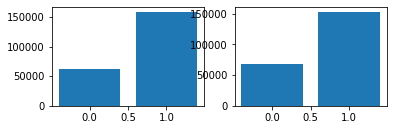

In [0]:
log_y_pred_df = pd.Series(log_y_pred)
y_test_results = y_test.value_counts()
classified_results = log_y_pred_df.value_counts()


plt.subplot(221)
plt.bar(classified_results.keys(), classified_results.values)
plt.subplot(222)
plt.bar(y_test_results.keys(), y_test_results.values)
# sns.barplot()
plt.show()

In [0]:
y_test

293767    1
855678    1
621401    0
343604    0
68207     1
         ..
693383    1
253190    0
408446    0
783782    1
128299    1
Name: pos_neg, Length: 220909, dtype: int64

In [0]:
df.pos_neg

0         1
1         0
2         1
3         0
4         0
         ..
883631    1
883632    1
883633    0
883634    0
883635    1
Name: pos_neg, Length: 883636, dtype: int64

In [0]:
stops = stopwords.words('english')

def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma


reviews = reviews.apply(lambda x: tokenize(str(x)))
df['pos_neg'] = [1 if x > 3 else 0 for x in df.overall]
X_test = vectorizer.transform(reviewsText)
y_test = df.pos_neg

loaded_model = joblib.load(filename)
log_y_pred = loaded_model.predict(X_test)
result = loaded_model.score(X_test, y_test)

print(result)


In [0]:
!pip freeze > requirements.txt
